# Лабораторная  №2, Вариант 13

Воробей Артём, 4группа, 4 курс. 

![task-1](task1.png)
![task-2](task2.png)


## Условия депонирования вклада из задания 1:
![wtf](pre-task.PNG)

# Моделирование 1000 реализаций $K_1$

Для того, смоделировать курс обмена рублей в валюту в j-й день $К_{1,j} = f(j) + \xi_j$ как курс марковскую зависимость с трендом, необходимо смоделировать значение тренда $f_j$ и маржи $xi_j$

$f(j) = 1830 + j$ -- детерменированная величина

$\xi(j)$ -- получается моделированием однородной цепи Маркова, по матрице одношаговых переходов $P=(p_{i,j})$ и начальному состоянию = 2.

---
Код ниже получает 1000 реализций $K_1$ в список `K_1_samples`

In [1]:
import numpy as np

np.random.seed(1234)           

In [2]:
class Randomizer:
        
    def next_bsv(self):
        return np.random.uniform(0, 1)

    
class MarginRandomizer:

    def __init__(self, init_state):
        self.marg_vals = (-1, 0, 2)
    
        self.P = [
            [0.2, 0.7, 0.1],
            [0.2, 0.5, 0.3],
            [0.2, 0.6, 0.2]]

        self.Q = [
            [0.2, 0.9, 1.0],
            [0.2, 0.7, 1.0],
            [0.2, 0.8, 1.0]]

        self.state = init_state
        
        self.rnd = Randomizer()
        
        
    def next_marg(self):
        """v -- current state 1..3"""
        
        a = self.rnd.next_bsv()
        
        q = self.Q[self.state - 1]
        # ищу следующее состояние следующее состояние и значение 
        for j, q_j in enumerate(q):
            if q_j >= a:
                self.state = j + 1
                return self.marg_vals[j]
    

In [3]:
# тренд в j-й день
def f(j):
    return 1830 + j

# маржа в j-й день
def margin(j):
    # начальное состояние -- второе
    margin_rnd = MarginRandomizer(init_state=2)  
    
    # генерирую и игнорирую j-1 значение.
    # j-е значение является искомой маржой.
    for _ in range(j):
        m = margin_rnd.next_marg()
    return m
    

# реализация курса обмена рублей в валюту в j-й день
# как марковской зависимости с трендом.
def K_1(j):
    return f(j) + margin(j)

Согласно условию:
* срок вклада `n` 3 месяца
* курс конверсии рублей в валюту на сегодняшний день `K_0` = 1820
* вклад в рублях под 50% годовых `r_coef`
* вклад в валюте под 10% годовых `v_coef`

In [4]:
n = 3 / 12
K_0 = 1820     # курс валюта -> рубль на сегодняшний день
r_coef = 0.50  # вклад в рублях под 50% годовых
v_coef = 0.10  # вклад в рублях под 10% годовых

last_day = int(n * 365) # срок вклада в днях
print('длитенльность вклада в днях:', last_day)

# 1000 реализаций курса
K_1_samples = [K_1(last_day) for _ in range(1000)]

длитенльность вклада в днях: 91


В результате были получены реализации $K_1$ со следующим распределением

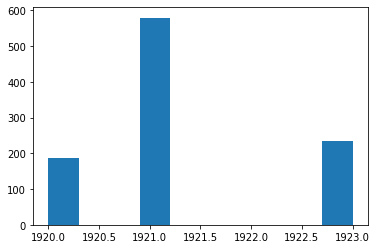

In [138]:
import matplotlib.pyplot as plt


plt.hist(K_1_samples)
plt.show()

# Оценка вероятности принятия альтернативных  решений


Пусть мы имеем $V$ единиц валюты на руках. 

$K_0$ -- курс обмена валюты в рубли на сегодняшний день.

$K_1$ -- курс обмена рублей в валюту на конец вклада.

$n$ -- срок вклада в годах.

$c_v, c_r$ -- доля прироста вклада за год.

Тогда, на конец вклада будем полчум единиц валюты:
1. при прямом валютном вкладе: $V * (1 + n * c_v)$ 
2. при вкладе с двойной конверсией:  $V * \frac{K_0 * (1 + n * c_r)}{K_1}$

При этом:

$P_1 = P\{\frac{K_0 * (1 + n * c_r)}{K_1} < 1\}$, вероятность того, что двойная конверсия убыточна.

$P_2 = P\{\frac{K_0 * (1 + n * c_r)}{K_1 * (1 + n * c_v)} > 1\}$, вероятность того, что двойная конверсия прибыльнее прямого вклада.

$P_3 = 1 - P_1 - P_2$, вероятность того, что прямой вклад всё равно выгоднее.

In [7]:
from functools import reduce

def get_prob(K_1):
    # множитель валюты при двойной конверсии 
    r = (K_0 * (1 + n * r_coef)) / K_1
    # множитель валюты при прямом вкладе
    v = (1 + n * v_coef)
    
    if r < 1:
        return (1, 0 , 0)
    elif r  > v:
        return (0, 1, 0)
    else:
        return (0, 0 , 1)

def aggr(agg, prob):
    return (agg[0] + prob[0], agg[1] + prob[1], agg[2] + prob[2])
    

ps = tuple(reduce(aggr, map(get_prob, K_1_samples)))
ps = [p / len(K_1_samples) for p in ps]

for i, p in enumerate(ps):
    print(f'P_{i+1} = {p}')

P_1 = 0.0
P_2 = 1.0
P_3 = 0.0


# Вывод

Вклад с двойной конверсией принесёт больше прибыли, чем прямой вклад в валюте, во всех случаях.